In [24]:
import os
import pandas as pd
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr, spearmanr

### 1. Load data ###

这一部分还需要做什么：
首先，是embedding的记录方法，记录成user_name: embedding_vector的map，但我觉得只有embedding_vectors的list也是需要的。
然后，再看看Francis的代码，看看他还用到了什么有用的处理数据的解决方案。

In [8]:
congress_to_embedding_dict = torch.load('data/output_data/global_embedding_kin3_kout1_dim20.pth', weights_only = True)

global_congress_table = pd.read_csv('data/raw_data/all_congress_members.csv')
global_congress_table.loc[:, 'twitter_name'] = global_congress_table['twitter_name'].str.lower()

In [18]:
def pca_reduction(user_to_vector_dict, n = 2):
    # Extract names and vectors
    names = list(user_to_vector_dict.keys())
    # vectors = np.array(list(user_to_vector_dict.values()))
    vectors = np.array(list(user_to_vector_dict.values()))


    # Perform PCA
    pca = PCA(n_components = n)
    reduced_vectors = pca.fit_transform(vectors)

    # Create a new dictionary with the reduced vectors
    reduced_dict = {name: reduced_vectors[i] for i, name in enumerate(names)}

    return reduced_dict

congress_to_pc_dict = pca_reduction(congress_to_embedding_dict)

print(len(congress_to_pc_dict))

for i, (key, value) in enumerate(congress_to_pc_dict.items()):
    if i >= 5:
        break
    print(key, value)

164
chuckgrassley [ 0.8328204 -0.9262324]
michelebachmann [ 1.5882026 -0.636244 ]
stabenow [-0.76238555  0.11759552]
greggharper [1.0717026  0.17469117]
repkevinbrady [0.77567184 0.574241  ]


81 102
73


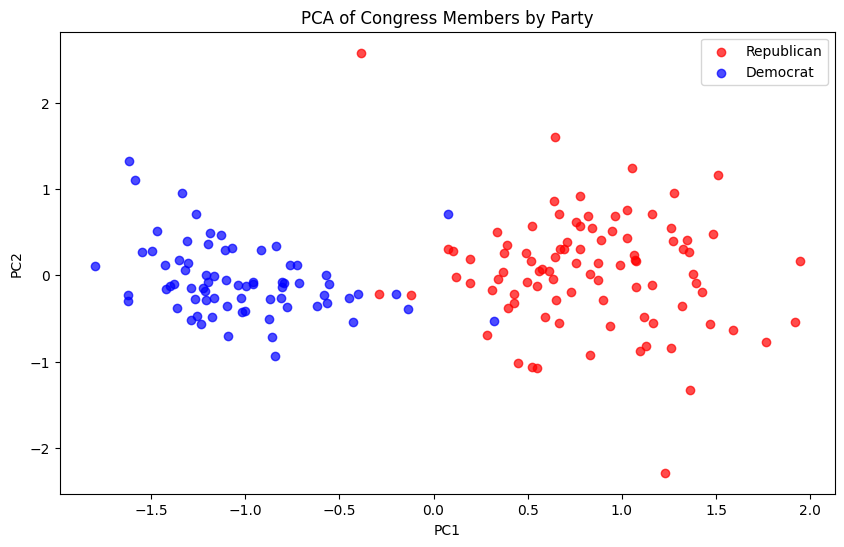

In [16]:
democrats = global_congress_table[global_congress_table['party'] == 'D']
republicans = global_congress_table[global_congress_table['party'] == 'R']

print(len(democrats), len(republicans))

republican_to_pc_dict = {}
democrat_to_pc_dict = {}

for (congress_member, pc_vector) in congress_to_pc_dict.items():
    if congress_member in democrats['twitter_name'].tolist():
        democrat_to_pc_dict[congress_member] = pc_vector
    else:
        republican_to_pc_dict[congress_member] = pc_vector

print(len(democrat_to_pc_dict))

# 提取共和党和民主党向量的 x 和 y 坐标
republican_x = [vec[0] for vec in republican_to_pc_dict.values()]
republican_y = [vec[1] for vec in republican_to_pc_dict.values()]
democrat_x = [vec[0] for vec in democrat_to_pc_dict.values()]
democrat_y = [vec[1] for vec in democrat_to_pc_dict.values()]

# 创建二维散点图
plt.figure(figsize=(10, 6))
plt.scatter(republican_x, republican_y, color='red', label='Republican', alpha=0.7)
plt.scatter(democrat_x, democrat_y, color='blue', label='Democrat', alpha=0.7)

# 添加图例和标签
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Congress Members by Party')
plt.legend()

# 显示图像
plt.show()

In [23]:
# Opinion estimation vs DW-NOMINATE
congress_to_pc_dw = {}

for (congress_member, pc) in congress_to_pc_dict.items():
    dw_value = global_congress_table.loc[global_congress_table['twitter_name'] == congress_member, 'DW-Nominate'].values[0]
    
    congress_to_pc_dw[congress_member] = (pc[0], dw_value)
    
print(len(congress_to_pc_dw))

for i, (key, value) in enumerate(congress_to_pc_dw.items()):
    if i >= 5:
        break
    print(key, value)
    
pc1s = [value[0] for value in congress_to_pc_dw.values()]
dw_values = [value[1] for value in congress_to_pc_dw.values()]

# 计算皮尔逊相关系数（线性相关性）
pearson_corr, _ = pearsonr(pc1s, dw_values)
print(f"Pearson Correlation (Linear): {pearson_corr}")

# 计算斯皮尔曼相关系数（单调相关性）
spearman_corr, _ = spearmanr(pc1s, dw_values)
print(f"Spearman Correlation (Monotonic): {spearman_corr}")

164
chuckgrassley (np.float32(0.8328204), np.float64(1.164748936))
michelebachmann (np.float32(1.5882026), np.float64(0.8905060836))
stabenow (np.float32(-0.76238555), np.float64(-1.147084774))
greggharper (np.float32(1.0717026), np.float64(0.6424128865))
repkevinbrady (np.float32(0.77567184), np.float64(1.053823653))
Pearson Correlation (Linear): 0.9131731703457735
Spearman Correlation (Monotonic): 0.820714703521826


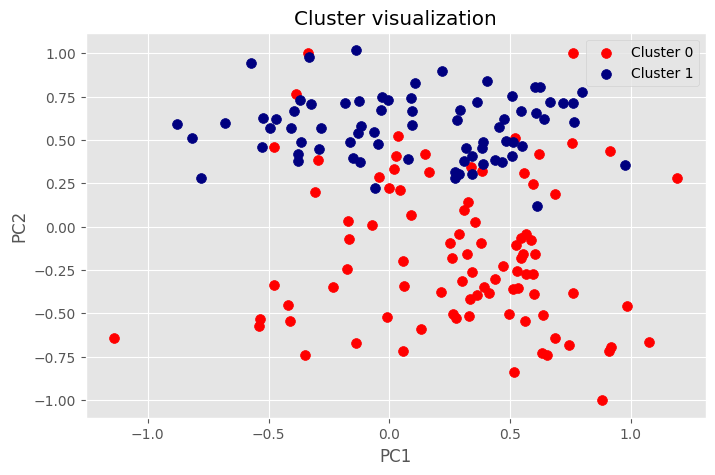

In [17]:
def kmeans_clustering(user_to_vector_dict, k = 2):
    # Convert the dictionary values to a NumPy array
    features = np.array(list(user_to_vector_dict.values()))

    # Initialize and fit the KMeans algorithm
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(features)

    # Get the cluster labels
    labels = kmeans.labels_

    # If you want to associate labels with the original names:
    labeled_data = dict(zip(user_to_vector_dict.keys(), labels))

    # Plotting
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 5))
        colors = ['red', 'navy',]  # Extend this list for more clusters

        for i in range(k):
            # Plot data points that are assigned to each cluster
            plt.scatter(features[labels == i, 0], features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')

        plt.title('Cluster visualization')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.grid(True)
        plt.show()

    return labeled_data

labeled_data = kmeans_clustering(congress_to_embedding_dict)

In [ ]:
# embedding_vectors_df = pd.read_csv('data/output_data/embedding_vectors.csv')
# embedding_vectors = torch.tensor(embedding_vectors_df.values)
# embedding_vectors_np = embedding_vectors.numpy()
# 
# global_edge_table = pd.read_csv('data/processed_data/global_edge_list.csv')
# congress_member_info = pd.read_csv('data/raw_data/all_congress_members.csv')
# 
# global_edge_list = list(global_edge_table.itertuples(index = False, name = None))
# congress_member_set = list(set(i[1] for i in global_edge_list))
# 
# full_congress_member_list = congress_member_info['twitter_name'].tolist()
# 
# congress_member_list = []
# 
# for congress_member in full_congress_member_list:
#     if congress_member not in congress_member_set:
#         continue
#     
#     congress_member_list.append(congress_member)
# 
# party_map = {
#     'R': 1,
#     'D': 0
# }
# 
# print(len(congress_member_list))
# print(congress_member_list)

### 2. K-Means clustering and validation ###

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding_vectors_np)

labels = kmeans.labels_

count = 0

for label, congress_member in zip(labels, congress_member_list):
    party = congress_member_info.loc[congress_member_info['twitter_name'] == congress_member, 'party'].values[0]
    
    if party_map[party] == label:
        count += 1
    
print(count)
print('Clustering labels: ' + str(labels))

### 3. Score estimation using PCA and validation ###

In [ ]:
component_num = 3

pca = PCA(n_components=component_num)

pc_vectors = pca.fit_transform(embedding_vectors_np)

explained_variance = pca.explained_variance_ratio_
print(f"解释的方差比例：{explained_variance}")

projections_on_pc1 = pc_vectors[:, 0]
projections_on_pc2 = pc_vectors[:, 1]

fig = plt.figure()

x = projections_on_pc1
y = projections_on_pc2

plt.figure()
plt.scatter(x, y, c = 'blue', marker = 'o')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('2D PCA Projection')
plt.grid(True)
plt.show()

那么，到此为止的coding work是围绕将全局关系数据进行处理、生成embedding vectors来降维、聚类、主成分分析，具体要点和尚存问题如下：
1. 读取数据，将关注表格和议会成员表格合并，生成信息较全的全局关注表格（但DW-nominate值并未合并进去）；提取除去议会成员之间关注关系的二元网络；在上述二元网络的基础上提取2015年以前的数据；基于2015年以前的二元网络，提取出纯粹的关注关系数据，即只有关注者和被关注者的edge list
【问题】首先，待分析的数据并不只有全局数据，还会有单独分析参议院和众议院的成员的需求，因此在代码中应将数据集和分析计算逻辑解偶；然后，数据的规整这一环节并未整合ground truth的数据；再然后，数据处理结果和Francis的处理结果有细微的差别，进一步比较工作仍有待进行。
2. 浅神经网络的训练，首先是用户名编码，在已经有了edge list的基础上，提取出edge list的两列，并分别进行取set，利用set构建用户名对升序整数序列的映射map，然后将map中的整数使用one hot编码，将两列的one hot编码作为神经网络的输入输出进行训练，训练后提取权重矩阵，以议会成员的one hot编码乘权重矩阵再加上偏置矩阵就得到了embedding vectors。
【问题】神经网络的参数设置，包括优化规则仍有待进一步确定，尤其是激活函数的选择，是否应该引入非线性；然后，，似乎此部分并无太多问题？
3. 拿到了embedding vectors之后，进行了kmeans clustering和PCA，之后评估了聚类准确度，以及画出了embedding vectors在PC1和PC2两个方向上的投影的二维点图。
【问题】首先，最难受的问题是embedding vectors和原数据（亦即原用户名的对应）；然后，聚类准确度的正确评估方法仍需进一步实现；然后，并未进行意识形态分数评估，以及与ground truth对比。

那么，接下来需要做什么？
1. 整理代码，现在的代码就是一坨垃圾，重构代码，加上必要的注释 by Oct 22
2. 跑出Francis的数据，或弄清楚为什么跑不出 by Oct 26
3. 估计意识形态分数和与ground truth对比 by Oct 26
4. 画出好图 by Oct 27
5. 复现Wang的工作 by Oct 31
6. 思路整理，flow chat，readme，etc. by Nov 1
7. 读nature那篇论文

Oct 23 todo: 1. 读Francis论文，看看还有哪些没有implement；2. 实现结果评估的方法，如线性相关系数、单调相关系数等。